# CNN for IED forecasting

This notebook implements a simple CNN for IED classification. The CNN has 4 convolutional layers, each followed by ReLU activation functions and max pooling. The task in this notebook is single channel and is therefore a more simple task than what will eventually be implemented, but is useful to show what we can do with our data using a CNN.

In [38]:
import numpy as np
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, BatchNormalization, Activation
from tensorflow.keras.activations import relu
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import Accuracy, AUC
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

Open the data and create training and test sets.

In [44]:
# Load the input data
X = np.load('X.npy')

# Load the labels
y = np.load('y.npy')

# Conver to a classification task: does the following window have 2 or more IEDs?
y = 1 * (y > 1)

# Split into training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert input data to [0, 1] range
scaler = MinMaxScaler()

# Fit to training data and transform both train & test
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Add dimension to make suitable for keras
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# As above for labels
y_train = y_train.reshape(y_train.shape[0], 1)
y_test = y_test.reshape(y_test.shape[0], 1)

We can see how balanced our data is:

In [45]:
np.sum(y_test > 0), np.sum(y_test <= 0)

(4053, 8619)

And can now define our model:

In [47]:
es = EarlyStopping(monitor="val_auc", patience=20, baseline=0.5, mode='max', restore_best_weights=True)

model = Sequential()

model.add(Conv1D(filters=8, kernel_size=2, input_shape=X_train[0].shape))
# model.add(BatchNormalization())
model.add(Activation(relu))
model.add(MaxPooling1D(pool_size=4))

model.add(Conv1D(filters=16, kernel_size=2))
# model.add(BatchNormalization())
model.add(Activation(relu))
model.add(MaxPooling1D(pool_size=4))
          
model.add(Conv1D(filters=16, kernel_size=2))
# model.add(BatchNormalization())
model.add(Activation(relu))
model.add(MaxPooling1D(pool_size=8))

model.add(Conv1D(filters=32, kernel_size=2))
# model.add(BatchNormalization())
model.add(Activation(relu))
model.add(MaxPooling1D(pool_size=8))

model.add(Flatten())
model.add(Dense(50))
# model.add(BatchNormalization())
model.add(Activation(relu))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[AUC(), Accuracy()])

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 20479, 8)          24        
_________________________________________________________________
activation_10 (Activation)   (None, 20479, 8)          0         
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 5119, 8)           0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 5118, 16)          272       
_________________________________________________________________
activation_11 (Activation)   (None, 5118, 16)          0         
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 1279, 16)          0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 1278, 16)         

Which we can now fit:

In [48]:
# fit model
history = model.fit(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[es])#, class_weight=class_weight)

Epoch 1/100
1268/1268 [==============================] - 88s 69ms/step - loss: 0.6300 - auc_2: 0.5023 - accuracy: 0.6805 - val_loss: 0.6315 - val_auc_2: 0.5241 - val_accuracy: 0.6749
Epoch 2/100
1268/1268 [==============================] - 85s 67ms/step - loss: 0.6317 - auc_2: 0.4995 - accuracy: 0.6749 - val_loss: 0.6303 - val_auc_2: 0.5577 - val_accuracy: 0.6749
Epoch 3/100
1268/1268 [==============================] - 85s 67ms/step - loss: 0.6328 - auc_2: 0.5104 - accuracy: 0.6723 - val_loss: 0.6279 - val_auc_2: 0.5940 - val_accuracy: 0.6749
Epoch 4/100
1268/1268 [==============================] - 85s 67ms/step - loss: 0.6252 - auc_2: 0.5626 - accuracy: 0.6757 - val_loss: 0.6261 - val_auc_2: 0.6147 - val_accuracy: 0.6749
Epoch 5/100
1268/1268 [==============================] - 85s 67ms/step - loss: 0.6185 - auc_2: 0.6031 - accuracy: 0.6716 - val_loss: 0.6132 - val_auc_2: 0.6258 - val_accuracy: 0.6749
Epoch 6/100
1268/1268 [==============================] - 87s 69ms/step - loss: 0.6101

Epoch 25/100
1268/1268 [==============================] - 91s 72ms/step - loss: 0.5843 - auc_2: 0.6796 - accuracy: 0.7016 - val_loss: 0.6107 - val_auc_2: 0.6856 - val_accuracy: 0.6928
Epoch 26/100
1268/1268 [==============================] - 88s 69ms/step - loss: 0.5786 - auc_2: 0.6845 - accuracy: 0.7073 - val_loss: 0.5918 - val_auc_2: 0.6891 - val_accuracy: 0.7008
Epoch 27/100
1268/1268 [==============================] - 87s 69ms/step - loss: 0.5788 - auc_2: 0.6841 - accuracy: 0.7064 - val_loss: 0.5797 - val_auc_2: 0.6917 - val_accuracy: 0.7019
Epoch 28/100
1268/1268 [==============================] - 88s 70ms/step - loss: 0.5742 - auc_2: 0.6904 - accuracy: 0.7109 - val_loss: 0.5806 - val_auc_2: 0.6964 - val_accuracy: 0.7076
Epoch 29/100
1268/1268 [==============================] - 88s 70ms/step - loss: 0.5772 - auc_2: 0.6891 - accuracy: 0.7062 - val_loss: 0.5905 - val_auc_2: 0.6887 - val_accuracy: 0.7064
Epoch 30/100
1268/1268 [==============================] - 88s 69ms/step - loss: 

1268/1268 [==============================] - 83s 66ms/step - loss: 0.5526 - auc_2: 0.7340 - accuracy: 0.7242 - val_loss: 0.5567 - val_auc_2: 0.7292 - val_accuracy: 0.7231
Epoch 49/100
1268/1268 [==============================] - 84s 66ms/step - loss: 0.5485 - auc_2: 0.7365 - accuracy: 0.7308 - val_loss: 0.5545 - val_auc_2: 0.7326 - val_accuracy: 0.7279
Epoch 50/100
1268/1268 [==============================] - 88s 70ms/step - loss: 0.5480 - auc_2: 0.7395 - accuracy: 0.7283 - val_loss: 0.5696 - val_auc_2: 0.7434 - val_accuracy: 0.7231
Epoch 51/100
1268/1268 [==============================] - 83s 66ms/step - loss: 0.5455 - auc_2: 0.7383 - accuracy: 0.7326 - val_loss: 0.5655 - val_auc_2: 0.7230 - val_accuracy: 0.7233
Epoch 52/100
1268/1268 [==============================] - 83s 66ms/step - loss: 0.5450 - auc_2: 0.7419 - accuracy: 0.7311 - val_loss: 0.5666 - val_auc_2: 0.7474 - val_accuracy: 0.7231
Epoch 53/100
1268/1268 [==============================] - 85s 67ms/step - loss: 0.5449 - auc_

Epoch 72/100
1268/1268 [==============================] - 1079s 851ms/step - loss: 0.5095 - auc_2: 0.7846 - accuracy: 0.7570 - val_loss: 0.5387 - val_auc_2: 0.7822 - val_accuracy: 0.7428
Epoch 73/100
1268/1268 [==============================] - 2030s 2s/step - loss: 0.5085 - auc_2: 0.7853 - accuracy: 0.7622 - val_loss: 0.5167 - val_auc_2: 0.7807 - val_accuracy: 0.7570
Epoch 74/100
1268/1268 [==============================] - 1005s 793ms/step - loss: 0.5025 - auc_2: 0.7926 - accuracy: 0.7611 - val_loss: 0.5190 - val_auc_2: 0.7872 - val_accuracy: 0.7577
Epoch 75/100
1268/1268 [==============================] - 83s 66ms/step - loss: 0.5045 - auc_2: 0.7911 - accuracy: 0.7633 - val_loss: 0.5172 - val_auc_2: 0.7855 - val_accuracy: 0.7554
Epoch 76/100
1268/1268 [==============================] - 1014s 801ms/step - loss: 0.5023 - auc_2: 0.7917 - accuracy: 0.7640 - val_loss: 0.5391 - val_auc_2: 0.7870 - val_accuracy: 0.7508
Epoch 77/100
1268/1268 [==============================] - 2053s 2s/step

Epoch 95/100
1268/1268 [==============================] - 85s 67ms/step - loss: 0.4824 - auc_2: 0.8100 - accuracy: 0.7784 - val_loss: 0.5007 - val_auc_2: 0.8027 - val_accuracy: 0.7721
Epoch 96/100
1268/1268 [==============================] - 84s 66ms/step - loss: 0.4782 - auc_2: 0.8142 - accuracy: 0.7794 - val_loss: 0.4903 - val_auc_2: 0.8095 - val_accuracy: 0.7747
Epoch 97/100
1268/1268 [==============================] - 85s 67ms/step - loss: 0.4791 - auc_2: 0.8152 - accuracy: 0.7794 - val_loss: 0.4889 - val_auc_2: 0.8088 - val_accuracy: 0.7780
Epoch 98/100
1268/1268 [==============================] - 86s 68ms/step - loss: 0.4798 - auc_2: 0.8127 - accuracy: 0.7794 - val_loss: 0.4910 - val_auc_2: 0.8070 - val_accuracy: 0.7752
Epoch 99/100
1268/1268 [==============================] - 85s 67ms/step - loss: 0.4786 - auc_2: 0.8164 - accuracy: 0.7777 - val_loss: 0.5067 - val_auc_2: 0.8013 - val_accuracy: 0.7636
Epoch 100/100
1268/1268 [==============================] - 86s 67ms/step - loss:

We can visualise the training & validation loss over time:

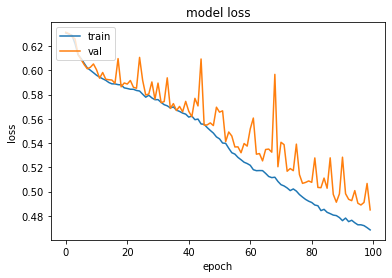

In [55]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

As above for accuracy:

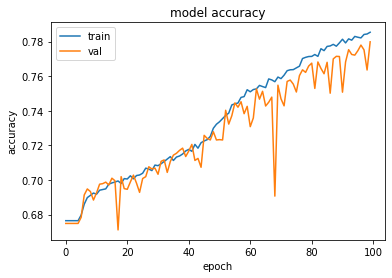

In [51]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()